# 基于SAM的图像分割

#### 基于SAM图像分割的实现思路
* 1、 首先是下载segment模型和权重参数。然后导入相关库，利用OpenCV加载并显示出图像，同时提取出图像的高度和宽度参数。将模型进行处理，设置权重和训练GPU等。创建一个模型的实例，对图像1进行处理得到mask1变量，包含许多mask变量。同时利用OpenCV提取并绘制出轮廓，即mask1中segment对应的内容，绘制出最终的结果。同样的处理方式对图像2进行处理。
* 2、进一步处理，将模型的参阈值数进行调整后，再次同样的步骤绘制出轮廓。
* 3、对噪声等进行进一步的过滤，对轮廓进行数值处理。之后可以计算出轮廓的面积，以及拟合的矩形面积进行比较，以及坐标的位置进行比较，最终可以得到较为干净的识别结果。

## 安装SAM算法库并下载模型的参数

In [2]:
install = True
if install:
    # 导入python的解释器路径
    import sys
    # shell命令，安装opencv-pyyhon 和 matplotlib两个库
    !{sys.executable} -m pip install opencv-python matplotlib
    # 从GitHub上安装segment-anything 库
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # 创建checkpoints新目录
    !mkdir checkpoints
    # 使用wget工具下载segment_anything权重
    !wget -P checkpoints https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 1.3 MB/s eta 0:00:31
   ---------------------------------------- 0.1/38.6 MB 1.1 MB/s eta 0:00:34
   ---------------------------------------- 0.2/38.6 MB 1.7 MB/s eta 0:00:23
   ---------------------------------------- 0.3/38.6 MB 2.1 MB/s eta 0:00:19
   ---------------------------------------- 0.5/38.6 MB 2.2 MB/s eta 0:00:18
    --------------------------------------- 0.9/38.6 MB 3.7 MB/s eta 0:00:11
   - -------------------------------------- 1.1/38.6 MB 4.2 MB/s eta 0:00:10
   - -------------------------------------- 1.6/38.6 MB 4.5 MB/s eta 0:00:09
   - -------------------------------------- 1.8/38.6 MB 4.9 MB/s eta 0:00:08
   - -------------------------------------- 1.8/38.6 MB 4.9 MB/s eta 0:00:08
   -- ------------------------------------- 2.3/38.6 MB 5.2 MB/s eta 0:00:08
   -- ------------------------------------- 2.8/38.6 MB 5.4 MB/s eta 0:00:07
   ---

ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/segment-anything.git'"
'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


## 加载测试用的图像

利用opencv读取图像。数据类型为uint8。

In [4]:
# track函数可在命令行中显示进度条
from rich.progress import track
# 导入numpy库，处理数值数据
import numpy as np
# 导入opencv库，用于读取和处理图像
import cv2 as cv
# 显示可视化结果
import matplotlib.pyplot as plt

# 导入pytorch
import torch
# torchvision库，提供常用的数据转换和预处理函数
import torchvision

# SAM模型进行图像分割的核心组件
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

def read_image(image_path):
    image = cv.imread(image_path)
    if image is None:
        raise Exception('Empty image!') # 抛出一个异常信息
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

# r代表原始字符串，“/”不会认为是转义字符
image1 = read_image(r'images/A0001.png')
image2 = read_image(r'images/A0100.png')
# image的三个数据，高度、宽度和通道数（RGB）
height, width, _ = image1.shape


Exception: Empty image!

图像1为货箱较为规整的样本。

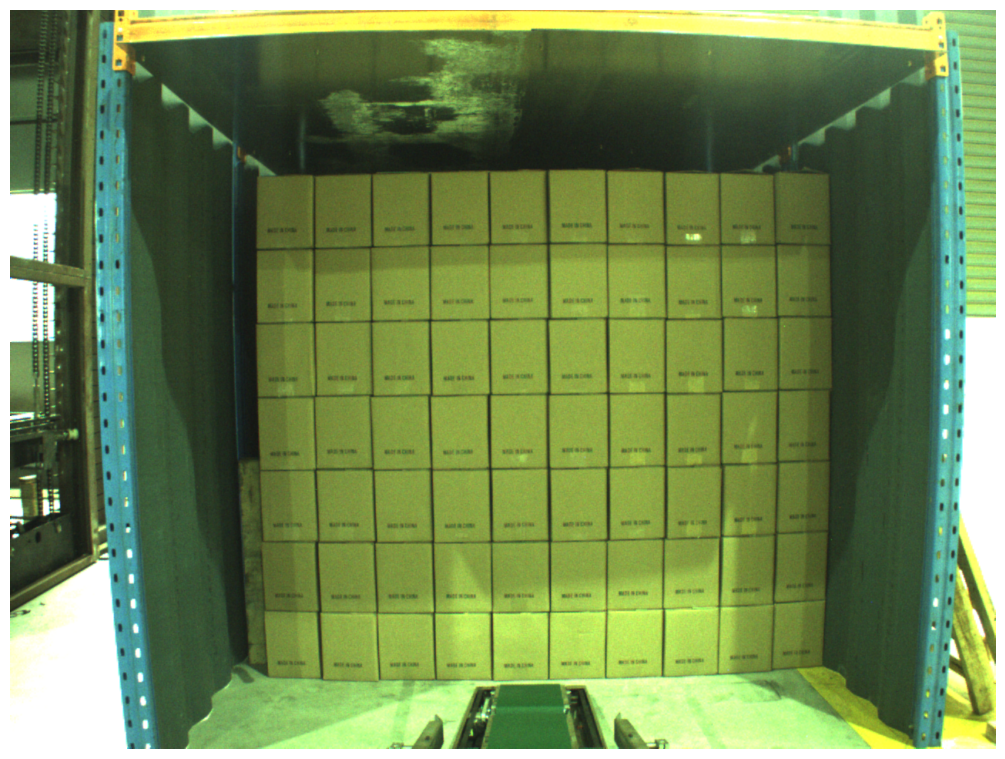

In [3]:
# 图像数据的处理通过cv.read进行读取，然后plt.imshow进行展示
# plt.show函数的作用为暂停运行，直至图像窗口被关闭
plt.figure(figsize=(12.8, 9.6))
plt.imshow(image1)
plt.axis('off')
plt.show()


图像2为货箱较为混杂，品种形状类型较多的样本。

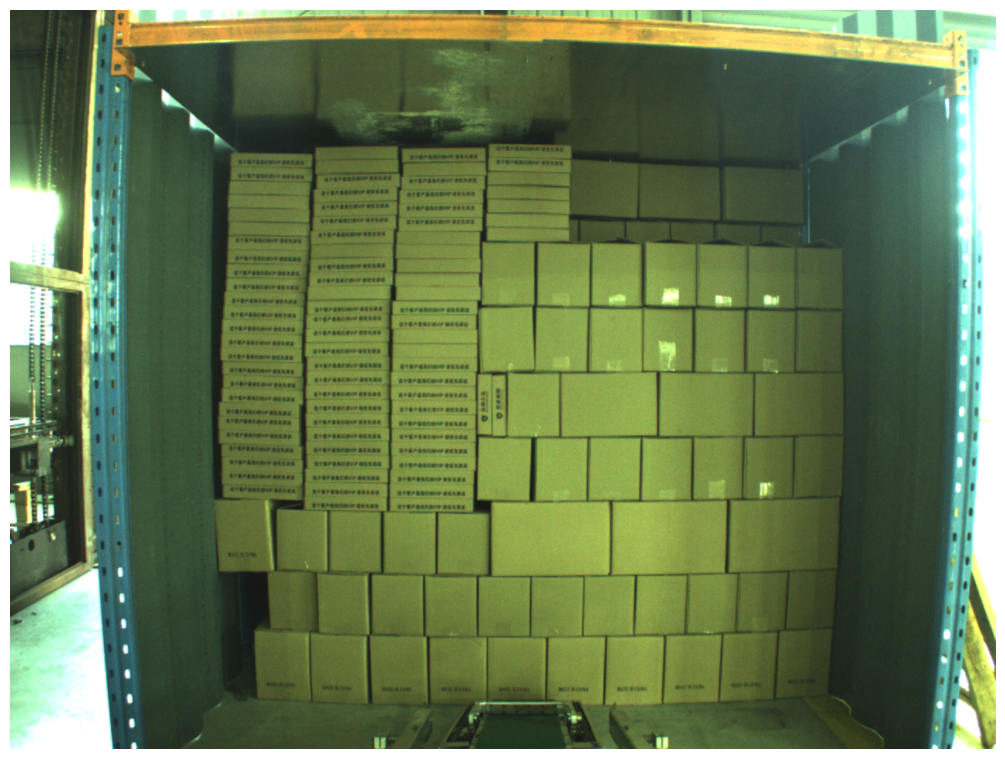

In [4]:
# 显示第二张图片内容
plt.figure(figsize=(12.8, 9.6))
plt.imshow(image2)
plt.axis('off')
plt.show()


## 利用SAM模型分割图像

加载SAM模型。识别算法的参数使用默认设置。

In [5]:
# 加载预训练权重的路径；定义模型的类型；设备
# 目的：从检查点文件加载预训练的模型
sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

利用识别算法搜寻图像中的各个物体。可以看到，图像1中的货物都能被正确识别到。

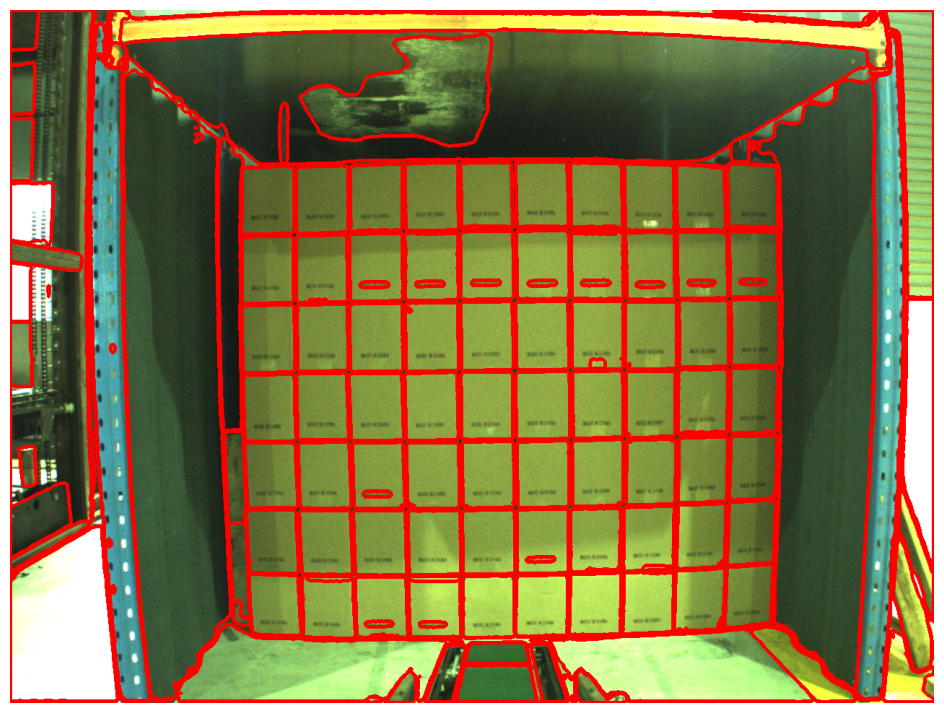

In [6]:
# 目的：便于在图像上标记感兴趣的区域
# 创建了一个segment类的实例
# mask1代表图像中的不同区域对象
mask_generator = SamAutomaticMaskGenerator(sam)
masks1 = mask_generator.generate(image1)

# 创建一个绘图对象，全白色
# 将image1中的信息复制到前三个通道
fig = np.ones((height, width, 4), np.uint8) * 255
fig[..., :3] = image1

# cv.findContours提取轮廓，cv.RETR_EXTERNAL只提取外层轮廓。
# cv.CHAIN_APPROX_SIMPLE 只保留端点
for mask in masks1:
    segmentation = mask['segmentation']
    contours, _ = cv.findContours(
        np.uint8(segmentation), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
    )
    # 绘制提取出的轮廓，颜色为蓝色，线宽为3像素
    cv.drawContours(fig, contours, -1, (255, 0, 0, 255), 3)

plt.figure(figsize=(12, 9))
plt.imshow(fig)
plt.axis('off')
plt.show()


图像2中，部分货物没有被正确识别到；部分货物被多个一组识别为了一个整体。

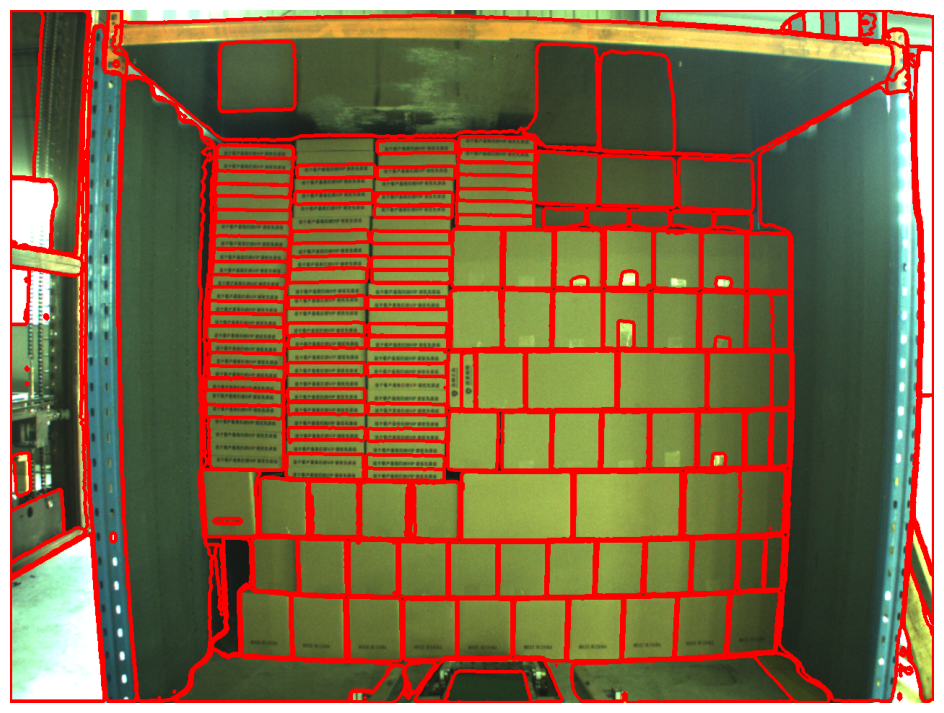

In [7]:
masks2 = mask_generator.generate(image2)

fig = np.ones((height, width, 4), np.uint8) * 255
fig[..., :3] = image2

for mask in masks2:
    segmentation = mask['segmentation']
    contours, _ = cv.findContours(
        np.uint8(segmentation), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
    )
    cv.drawContours(fig, contours, -1, (255, 0, 0, 255), 3)

plt.figure(figsize=(12, 9))
plt.imshow(fig)
plt.axis('off')
plt.show()


更改算法参数。降低各阈值，增加识别次数。可以看到计算时间显著增加，但图像中的所有货物都能被正确识别到。

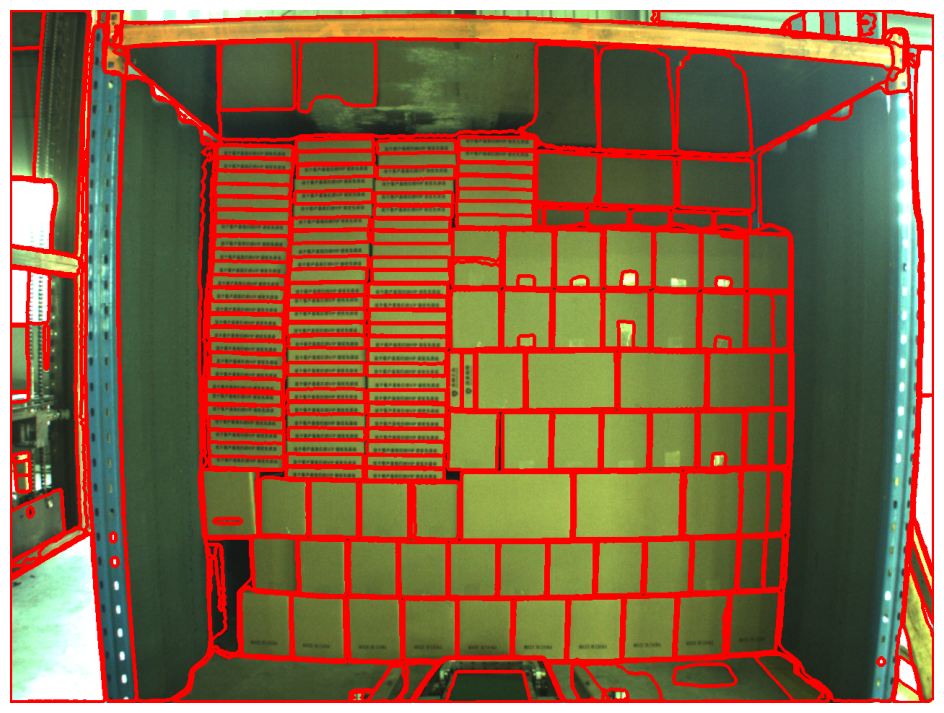

In [8]:
# 参数含义：模型、采样点、阈值超过有效、稳定性阈值、掩码区域可减去噪声和不重要的区域
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)
masks2 = mask_generator_2.generate(image2)

# np.unit8代表无符号数8位整数，取值范围0~255
fig = np.ones((height, width, 4), np.uint8) * 255
fig[..., :3] = image2

for mask in masks2:
    segmentation = mask['segmentation']
    contours, _ = cv.findContours(
        np.uint8(segmentation), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
    )
    cv.drawContours(fig, contours, -1, (255, 0, 0, 255), 3)

plt.figure(figsize=(12, 9))
plt.imshow(fig)
plt.axis('off')
plt.show()


## 基于OpenCV的过滤方法
- 利用传统的方法，过滤掉位于图像边缘、形状与长方形相差较大、面积过大或过小的干扰元素。
- 在设定好合适的参数后可以达到较好的效果，但参数依赖于人为设定，在更换场景后将不再适用。
- 未来可以利用分类算法进行过滤，可以达到更高的自动化程度，和更高的精度。

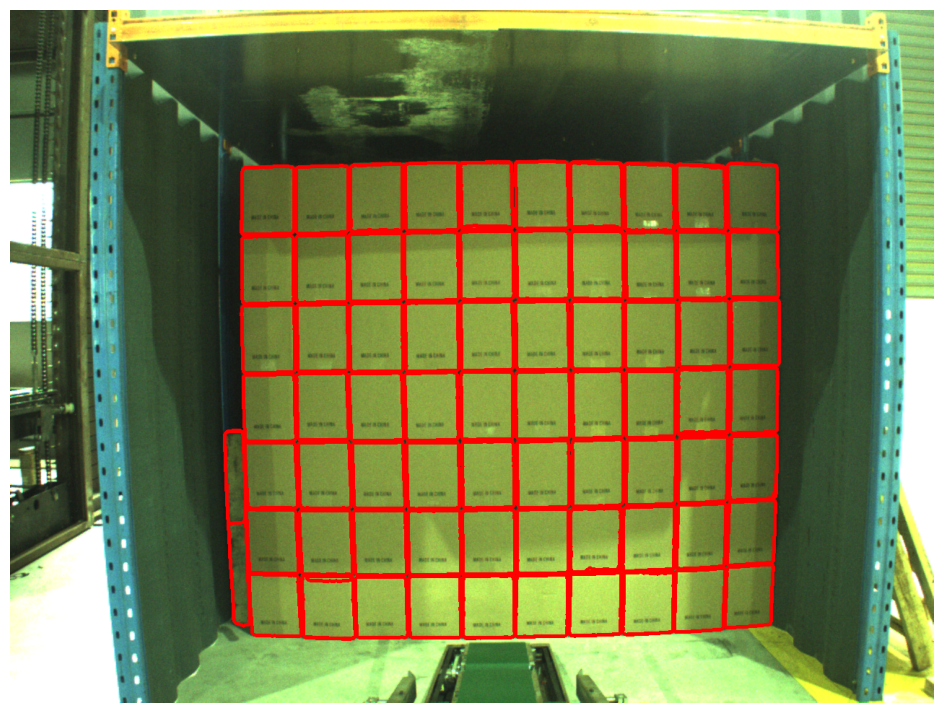

In [9]:
fig = np.ones((height, width, 4), np.uint8) * 255
fig[..., :3] = image1

for mask in masks1:
    segmentation = mask['segmentation']
    contours, _ = cv.findContours(
        np.uint8(segmentation), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
    )
    # contour赋值操作
    if len(contours) > 1:
        continue
    (contour,) = contours

    # 计算轮廓的面积、拟合轮廓的最小矩形。保存坐标。
    # 坐标值，左上角坐标、宽度和高度
    area = cv.contourArea(contour)
    rect = cv.minAreaRect(contour)
    mask['rect'] = rect
    (x, y), (w, h), _ = rect

    # 判断坐标的位置，跳过轮廓处理
    if x < width * 0.1 or x > width * 0.9 or y < height * 0.15 or y > height * 0.9:
        continue
    rect_area = w * h
    if area < 1000 or area > 100000:
        continue
    if area / rect_area < 0.85:
        continue

    cv.drawContours(fig, contours, -1, (255, 0, 0, 255), 3)

plt.figure(figsize=(12, 9))
plt.imshow(fig)
plt.axis('off')
plt.show()


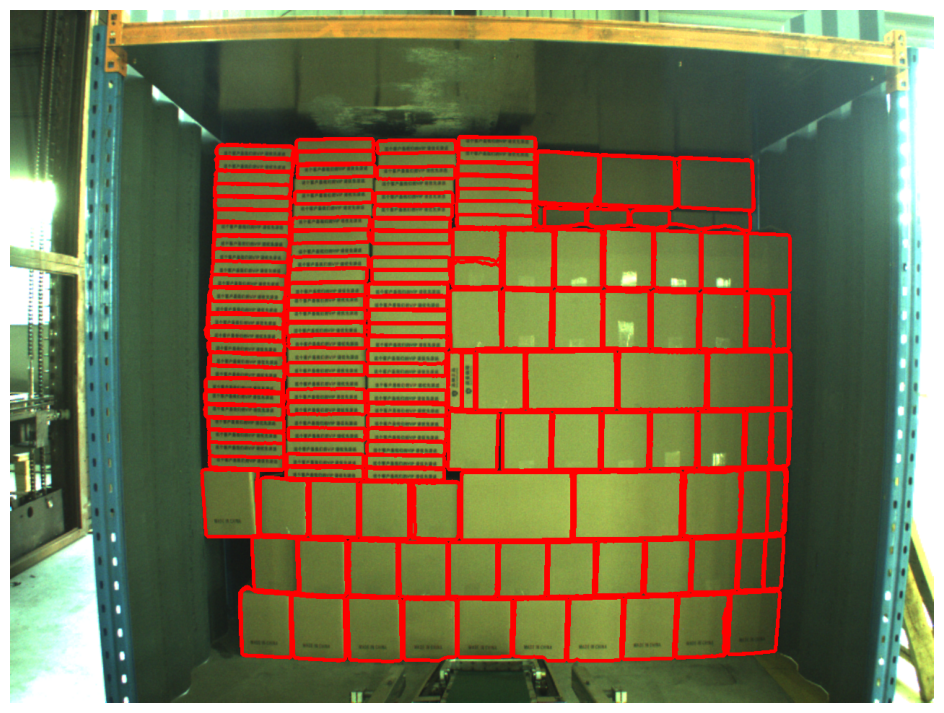

In [10]:
fig = np.ones((height, width, 4), np.uint8) * 255
fig[..., :3] = image2

for mask in masks2:
    segmentation = mask['segmentation']
    contours, _ = cv.findContours(
        np.uint8(segmentation), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
    )

    if len(contours) > 1:
        continue
    (contour,) = contours

    area = cv.contourArea(contour)
    rect = cv.minAreaRect(contour)
    mask['rect'] = rect
    (x, y), (w, h), _ = rect

    if x < width * 0.1 or x > width * 0.9 or y < height * 0.15 or y > height * 0.9:
        continue
    rect_area = w * h
    if area < 1000 or area > 100000:
        continue
    if area / rect_area < 0.85:
        continue

    cv.drawContours(fig, contours, -1, (255, 0, 0, 255), 3)

plt.figure(figsize=(12, 9))
plt.imshow(fig)
plt.axis('off')
plt.show()
